In [1]:
import sys
sys.path.append("../../")

In [2]:
from functions.floodmodel_utils import get_basin_mask, get_river_mask
from functions.floodmodels import reshape_scalar_predictand
import xarray as xr
#Creating a Dask local cluster for parallel computing (making the computations later on much faster)
from dask.distributed import Client, LocalCluster


In [3]:
#HYPERPARAMETERS
days_intake_length = 90
forecast_day = 30


#LIBRARY IMPORTS
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster


#Connecting to a cluster to be able to run the code locally/on the cloud
#cluster = LocalCluster()  # n_workers=10, threads_per_worker=1,
client = Client(processes=False)


/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
#This will tell you where you dashboard will be so you can visualize your model being run
print(client.scheduler_info()['services'])

{'dashboard': 61113}


In [5]:
#Loading the transformed dataset
#glofas_loaded = xr.open_dataset("/tmp/flood_prediction/pipeline/data_download:upload/reshaped_glofas_2019.nc")
glofas_loaded = xr.open_mfdataset("../../data/glofas_sample/Elbe/glofas_masked_elbe_*.nc")

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [6]:
era5_loaded = xr.open_mfdataset("../../data/Elbe/reanalysis-era5-single-levels_convective_precipitation,land_sea_mask,large_scale_precipitation,runoff,slope_of_sub_gridscale_orography,soil_type,total_column_water_vapour,volumetric_soil_water_layer_1,volumetric_soil_water_layer_2_*.nc", combine="by_coords")

In [7]:
era5_loaded

<xarray.Dataset>
Dimensions:    (latitude: 25, longitude: 33, time: 180367)
Coordinates:
  * longitude  (longitude) float32 9.0 9.25 9.5 9.75 ... 16.25 16.5 16.75 17.0
  * latitude   (latitude) float32 54.0 53.75 53.5 53.25 ... 48.5 48.25 48.0
  * time       (time) datetime64[ns] 1999-01-01 ... 2019-11-29T06:00:00
Data variables:
    cp         (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    lsm        (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    lsp        (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    slor       (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    slt        (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-12-02 16:58:32 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [8]:
era5 = era5_loaded.copy()

In [9]:
glofas_loaded

<xarray.Dataset>
Dimensions:    (latitude: 54, longitude: 71, time: 6575)
Coordinates:
  * longitude  (longitude) float64 9.25 9.35 9.45 9.55 ... 16.05 16.15 16.25
  * latitude   (latitude) float64 53.85 53.75 53.65 53.55 ... 48.75 48.65 48.55
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2016-12-31
Data variables:
    dis24      (time, latitude, longitude) float32 dask.array<chunksize=(2557, 54, 71), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.9.6 (http://m...
    Conventions:               CF-1.6
    history:                   Thu Oct 10 12:28:51 2019: cdo -seldate,1999-01...
    cdo_openmp_thread_number:  8
    NCO:                       netCDF Operators version 4.7.8 (Homepage = htt...
    CDO:                       Climate Data Operators version 1.9.6 (http://m...

In [10]:
y_orig = glofas_loaded
#Making a copy because y will be transformed to represent the variation of discharge. The model will be predicting the variation of discharge, not the quantity of discharge itself
y = y_orig

#Era5 will be the predictor dataset


In [11]:
period_train = dict(time=slice(None, '2012'))
period_test = dict(time=slice('2013', '2016'))


In [12]:
elbe_basin_mask = get_basin_mask(glofas_loaded['dis24'].isel(time=0), 'Elbe')

In [13]:
#Reshape to align in coordinates
era5_masked = era5.interp(latitude=y.latitude, longitude=y.longitude).where(elbe_basin_mask, drop=True)
X = era5_masked


#Downsampling our time from hourly to daily
X = X.resample(time='1D').mean()


In [14]:
X_point = X.isel(latitude=3, longitude=6)

In [15]:
y_point = y.isel(latitude=3, longitude=6)

In [16]:
X_point = X_point.drop(['latitude','longitude'])
y_point = y_point.drop(['latitude','longitude'])

In [44]:
X_point

<xarray.Dataset>
Dimensions:  (time: 7638)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2019-11-29
Data variables:
    cp       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    lsm      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    lsp      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ro       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    slor     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    slt      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    tcwv     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    swvl1    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    swvl2    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


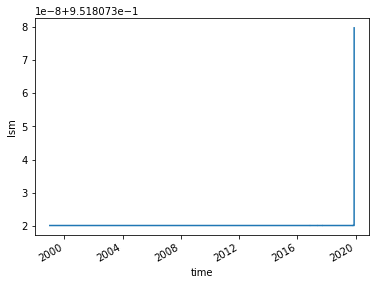

In [46]:
X_point['lsm'].plot()

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


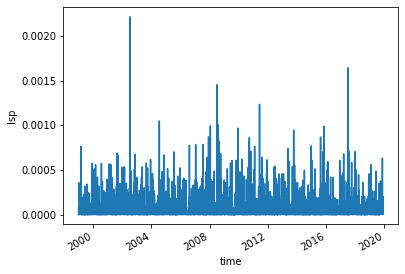

In [47]:
X_point['lsp'].plot()

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


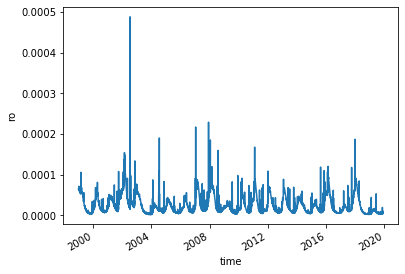

In [48]:
X_point['ro'].plot()

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


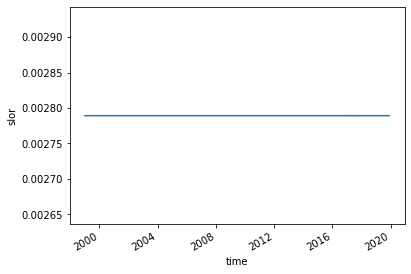

In [49]:
X_point['slor'].plot()

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


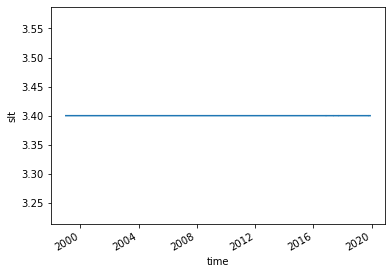

In [50]:
X_point['slt'].plot()

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


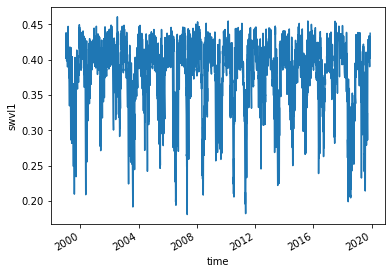

In [51]:
X_point['swvl1'].plot()

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


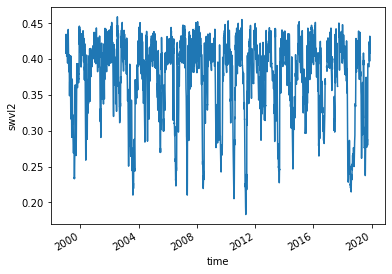

In [52]:
X_point['swvl2'].plot()

In [17]:
Xda, yda = X_point.to_array('features').T, y_point['dis24']

In [57]:
Xda = Xda.dropna('time')

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [67]:
Xda = Xda.loc[dict(time=slice(None, '2016'))]
yda = yda.loc[dict(time=slice(None, '2016'))]

In [ ]:
Xda, yda = xr.align(Xda, yda)

In [107]:
period_train = dict(time=slice(None, '2016'))
period_test = dict(time=slice('2013', '2016'))



X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]


In [108]:
y_train.values

array([868.8705, 868.3902, 867.6642, ..., 285.6408, 284.7062, 284.1858],
      dtype=float32)

In [152]:
import numpy as np

#Applying feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
# X_train_scaled = sc.fit_transform(X_train)
sc2 = MinMaxScaler(feature_range=(0,1))
# y_train_scaled = sc2.fit_transform(y_train.values.reshape(-1,1))

In [153]:
from functions.floodmodels import shift_input
# X_train_final, y_train_final = shift_input(X_train_scaled, y_train_scaled, days_intake_length, 1)

In [111]:
y_train_final = y_train_final.reshape(-1)

In [112]:
y_train_final

array([0.336893  , 0.33814436, 0.3365817 , ..., 0.01972612, 0.01941633,
       0.0191493 ], dtype=float32)

In [155]:
X_test_scaled = sc.fit_transform(X_test)
y_test_scaled = sc2.fit_transform(y_test.values.reshape(-1,1))

X_test_final, y_test_final = shift_input(X_test_scaled, y_test_scaled, days_intake_length, 1)
y_test_final = y_test_final.reshape(-1)

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


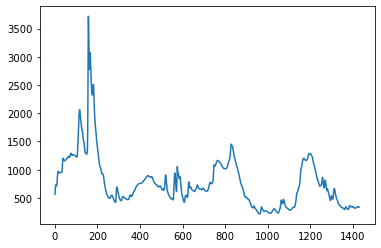

In [151]:
plt.plot(sc2.inverse_transform(y_test_scaled).reshape(-1))

In [96]:
y_test_final

array([0.29808316, 0.2975388 , 0.29692933, ..., 0.03557674, 0.03498764,
       0.03447982], dtype=float32)

In [123]:
#LSTM MODEL
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.core import Dropout


regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences= True, input_shape=(X_test_final.shape[1], X_test_final.shape[2]))) #(n_timesteps, n_features)#(n_sample, n_timesteps, n_features)
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=100, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=100, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=100))
regressor.add(Dropout(0.1))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

In [124]:
training_history = regressor.fit(X_test_final, y_test_final, epochs=200, batch_size=32)

Epoch 1/200
1340/1340 [==============================] - 14s 10ms/step - loss: 0.0188
Epoch 2/200
1340/1340 [==============================] - 12s 9ms/step - loss: 0.0170
Epoch 3/200
1340/1340 [==============================] - 18s 13ms/step - loss: 0.0168
Epoch 4/200
1340/1340 [==============================] - 12s 9ms/step - loss: 0.0162
Epoch 5/200
1340/1340 [==============================] - 9s 7ms/step - loss: 0.0157
Epoch 6/200
1340/1340 [==============================] - 9s 7ms/step - loss: 0.0149
Epoch 7/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0149
Epoch 8/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0137
Epoch 9/200
1340/1340 [==============================] - 9s 7ms/step - loss: 0.0139
Epoch 10/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0131
Epoch 11/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0142
Epoch 12/200
1340/1340 [==============================] - 9s 7ms

1340/1340 [==============================] - 10s 7ms/step - loss: 0.0047
Epoch 97/200
1340/1340 [==============================] - 9s 7ms/step - loss: 0.0047
Epoch 98/200
1340/1340 [==============================] - 9s 7ms/step - loss: 0.0045
Epoch 99/200
1340/1340 [==============================] - 9s 7ms/step - loss: 0.0045
Epoch 100/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0046
Epoch 101/200
1340/1340 [==============================] - 9s 7ms/step - loss: 0.0045
Epoch 102/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0046
Epoch 103/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0045
Epoch 104/200
1340/1340 [==============================] - 9s 7ms/step - loss: 0.0045
Epoch 105/200
1340/1340 [==============================] - 11s 8ms/step - loss: 0.0046
Epoch 106/200
1340/1340 [==============================] - 9s 7ms/step - loss: 0.0044
Epoch 107/200
1340/1340 [==============================] - 10s 7ms

1340/1340 [==============================] - 10s 7ms/step - loss: 0.0093
Epoch 191/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0118
Epoch 192/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0079
Epoch 193/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0074
Epoch 194/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0052
Epoch 195/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0100
Epoch 196/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0047
Epoch 197/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0040
Epoch 198/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0041
Epoch 199/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0039
Epoch 200/200
1340/1340 [==============================] - 10s 7ms/step - loss: 0.0038


In [125]:
#SAVING THE MODEL
# serialize model to YML
regressor_yaml = regressor.to_yaml()
with open("../../models/Elbe/elbe_model.yaml", "w") as yaml_file:
    yaml_file.write(regressor_yaml)
# serialize weights to HDF5
regressor.save_weights("../../models/Elbe/elbe_model.h5")
#Seialize feature scaling weights

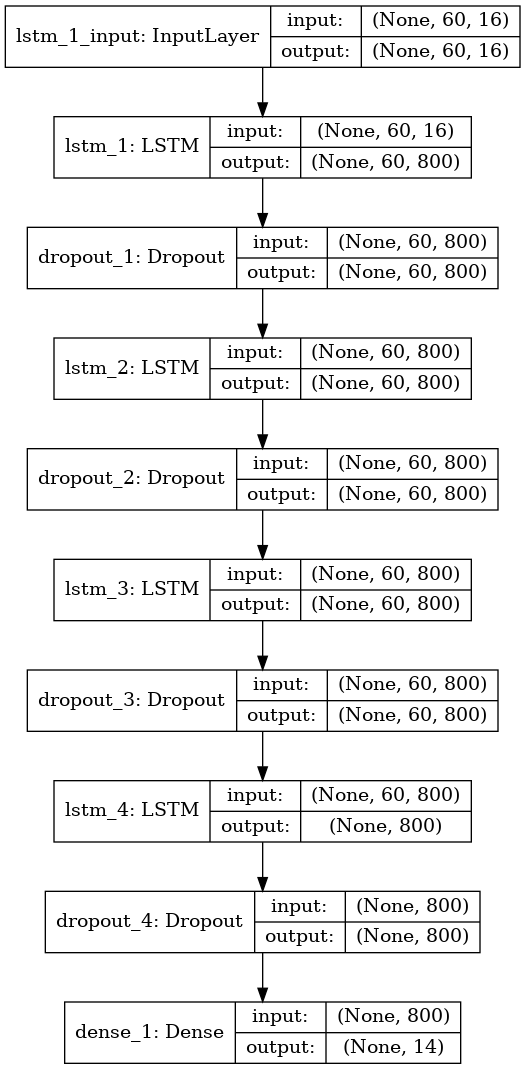

In [2]:
from keras.utils import plot_model
import pydot

plot_model(regressor, to_file='../images/Elbe/model.png', show_shapes=True)

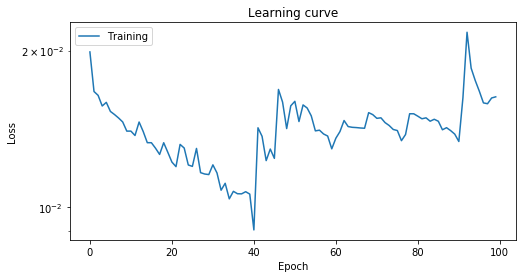

In [102]:
#TODO: Add error bar from code
#Visualizing the loss functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(training_history.history['loss'], label='loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training'])
ax.set_yscale('log')

In [121]:
#LATER ON...LOADING THE MODEL
regressor_model = open('../../models/Elbe/elbe_model.yaml', 'r').read()
from keras.models import model_from_yaml
loaded_regressor = model_from_yaml(regressor_model)
loaded_regressor.load_weights('../../models/Elbe/elbe_model.h5')
regressor = loaded_regressor

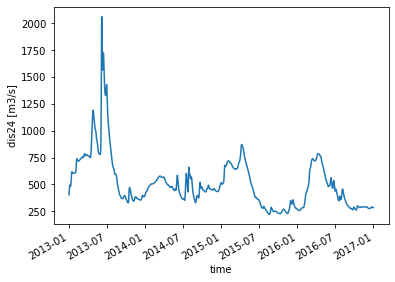

In [147]:
y_test.plot()

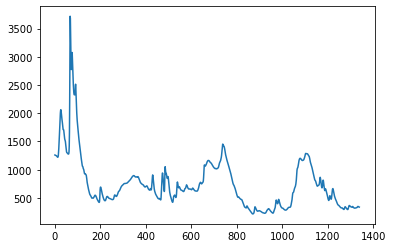

In [144]:
import matplotlib.pyplot as plt
plt.plot(sc2.inverse_transform(y_test_final.reshape(-1,1)))

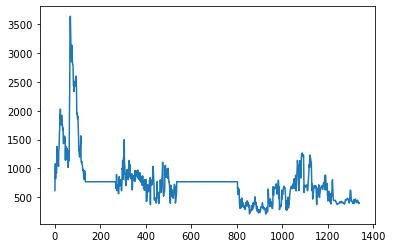

In [126]:
plt.plot(sc2.inverse_transform(regressor.predict(X_test_final).reshape(-1,1)))

In [131]:
y_pred_test = sc2.inverse_transform(regressor.predict(X_test_final))

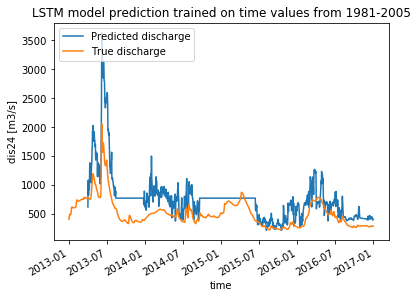

In [132]:
y_pred_test_xr = xr.DataArray(y_pred_test.reshape(-1), dims=('time'), coords={'time': y_test.time.values[days_intake_length+1:]})
y_pred_test_xr.plot(label = "Predicted discharge")

#Plotting the real validation values
#y_valid = np.concatenate(([y_orig.sel(time='2005-12-31').values], y_valid.values)).cumsum()
#y_valid = np.delete(y_valid, 0)
y_test_xr = xr.DataArray(y_test, dims=('time'), coords={'time': y_test.time.values})
y_test_xr.plot(label="True discharge")
plt.title('LSTM model prediction trained on time values from 1981-2005')
plt.legend(loc='upper left')
# plt.savefig('./images/sampleanalysis/LSTM_ver3_multivariate_discharge_validationdata.png', dpi=600)




In [138]:
y_pred_test - 200

array([[416.2188 ],
       [780.27246],
       [882.0581 ],
       ...,
       [189.44678],
       [197.48495],
       [202.44385]], dtype=float32)

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Text(0.5, 1.0, 'Comparison of LSTM Model with GloFAS 30-Day Ensemble Forecasts')

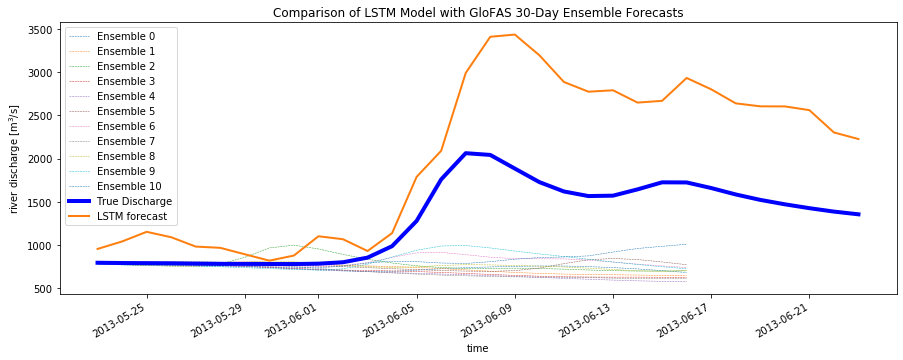

In [143]:
eps = xr.open_dataset('/Volumes/portableHardDisk/data/EPS/europeEPS201305/glofas2.1_2018_areagrid_for_StevenGong_in_Europe_2013051700.nc')
glofas = xr.open_mfdataset('../../data/glofas_sample/Elbe/glofas_masked_elbe_*.nc')

eps = eps.rename({'lat': 'latitude'})
eps = eps.rename({'lon': 'longitude'})

elbe_basin_mask = get_basin_mask(eps.isel(time=0, ensemble=0)['dis'], 'Elbe')
eps_masked = eps.where(elbe_basin_mask, drop=True)
point_eps_masked = eps_masked.isel(latitude=3, longitude=6)['dis']

glofas_point = glofas.loc[dict(time=slice('2013-05-23','2013-06-23'))].isel(latitude=3, longitude=6)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
color_scheme = ['g', 'cyan', 'magenta', 'k']


for ensemble_index in range(len(point_eps_masked.ensemble)):
    point_eps_masked.loc[dict(time=slice('2013-05-23','2013-06-23'))].isel(ensemble=ensemble_index).plot(ax=ax, label=('Ensemble ' + str(ensemble_index)), lw=0.5, linestyle='--')
    
glofas_point['dis24'].plot(ax=ax, label=('True Discharge'), lw=4, linestyle='-', color='blue')
(y_pred_test_xr-200).loc[dict(time=slice('2013-05-23','2013-06-23'))].plot(ax=ax, label=("LSTM forecast"), lw=2, linestyle='-')
ax.set_ylabel('river discharge [m$^3$/s]')

ax.legend(loc='upper left')                

plt.title('Comparison of LSTM Model with GloFAS 30-Day Ensemble Forecasts')
